# Predicción del Precio de las Viviendas

#### Importación de librerias

In [338]:
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


import warnings
warnings.filterwarnings('ignore')

In [339]:
import sys
sys.path.append('utils.py')

# Importa funciones de utils.py
from utils import get_mae_graficos

#### Lectura de Datos

In [340]:
with open("data/data.pkl", "rb") as file:
    df = pickle.load(file)

In [341]:
df=df[['precio','baños','cocheras','dormitorios','area_constr','area_total','chimenea','jacuzzi','aire_acondicionado','area_deportiva','hall_ingreso','areas_verdes','desague','piscina','sauna','area_bbq']]

### Tratamiento de Valores Nulos

#### Verificación de Nulos

In [342]:
def porcentajeNulos(df, umbral):
    # Calcula el porcentaje de nulos por columna

    porcentajeNulos = df.isna().sum().sort_values(ascending=False) / len(df)
    # Filtra las columnas que superan el umbral
    columnas = porcentajeNulos[(porcentajeNulos> umbral)]

    # Muestra el resultado
    if not columnas.empty:
        print("Columnas con menos del {}% de valores nulos:".format(umbral * 100))
        print(columnas)
    else:
        print("No hay columnas con menos del {}% de valores nulos.".format(umbral * 100))

porcentajeNulos(df, umbral=0)

Columnas con menos del 0% de valores nulos:
chimenea              0.337410
jacuzzi               0.337410
aire_acondicionado    0.337410
desague               0.337410
sauna                 0.337410
area_deportiva        0.331646
hall_ingreso          0.331646
areas_verdes          0.331646
piscina               0.331646
area_bbq              0.331646
area_total            0.000141
dtype: float64


###  Eliminación de Valores faltantes

In [343]:
#Uso de complete case analysis (CCA) este método es útil si el porcentaje de valor faltante es inferior al 5% en una característica
df = df.dropna(subset=['area_total'])
df = df.reset_index(drop=True)

In [344]:
df.shape

(7112, 16)

### PCA

In [345]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)

In [346]:
from sklearn.decomposition import PCA

def pca_dec(data, n):
    pca = PCA(n)
    X_dec = pca.fit_transform(data)
    return X_dec, pca

In [347]:
# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)


## División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)


#Decomposing the train set:
pca_train_results, pca_train = pca_dec(X_train, 10)

#Decomposing the test set:
pca_test_results, pca_test = pca_dec(X_test, 10)

#Creating a table with the explained variance ratio
names_pcas = [f"PCA Component {i}" for i in range(1, 11, 1)]

scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])

# Formatear la columna "Explained Variance Ratio" para evitar notación científica
scree["Explained Variance Ratio"] = scree["Explained Variance Ratio"].apply(lambda x: f'{x:.10f}')


print(scree)

          Component Explained Variance Ratio
0   PCA Component 1             0.9489168997
1   PCA Component 2             0.0510829516
2   PCA Component 3             0.0000000592
3   PCA Component 4             0.0000000302
4   PCA Component 5             0.0000000136
5   PCA Component 6             0.0000000101
6   PCA Component 7             0.0000000072
7   PCA Component 8             0.0000000059
8   PCA Component 9             0.0000000051
9  PCA Component 10             0.0000000048


In [348]:
# Obtener las columnas de tu DataFrame original 'data'
column_names = data.drop(['precio'], axis=1).columns

# Crear DataFrame con las componentes principales del primer componente
df2 = pd.DataFrame({'PCA': pca_train.components_[0], 'Variable Names': column_names})

# Ordenar el DataFrame por el valor de las componentes principales
df2 = df2.sort_values('PCA', ascending=False)

df2["PCA"] = df2["PCA"].apply(lambda x: f'{x:.10f}')

# Imprimir el DataFrame resultante
print(df2)


              PCA      Variable Names
4    0.7514040888          area_total
3    0.6598423260         area_constr
1    0.0000135364            cocheras
5    0.0000025614            chimenea
12   0.0000007834             piscina
13   0.0000005307               sauna
9    0.0000005020        hall_ingreso
6    0.0000003699             jacuzzi
7    0.0000000830  aire_acondicionado
2   -0.0000002408         dormitorios
0   -0.0000010161               baños
11  -0.0000016916             desague
8   -0.0000025334      area_deportiva
14  -0.0000025912            area_bbq
10  -0.0000033617        areas_verdes


In [349]:
df=df[['precio','baños','cocheras','dormitorios','area_total','chimenea','jacuzzi','aire_acondicionado','hall_ingreso','piscina','sauna']]

### Regresión Lineal Multiple

#### Paso N° 1 Eliminando registros nulos de columnas Categóricas

In [350]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)

El valor mínimo de MAE es: 440044.51 cuando test_size: 0.3 y random_state es: 42



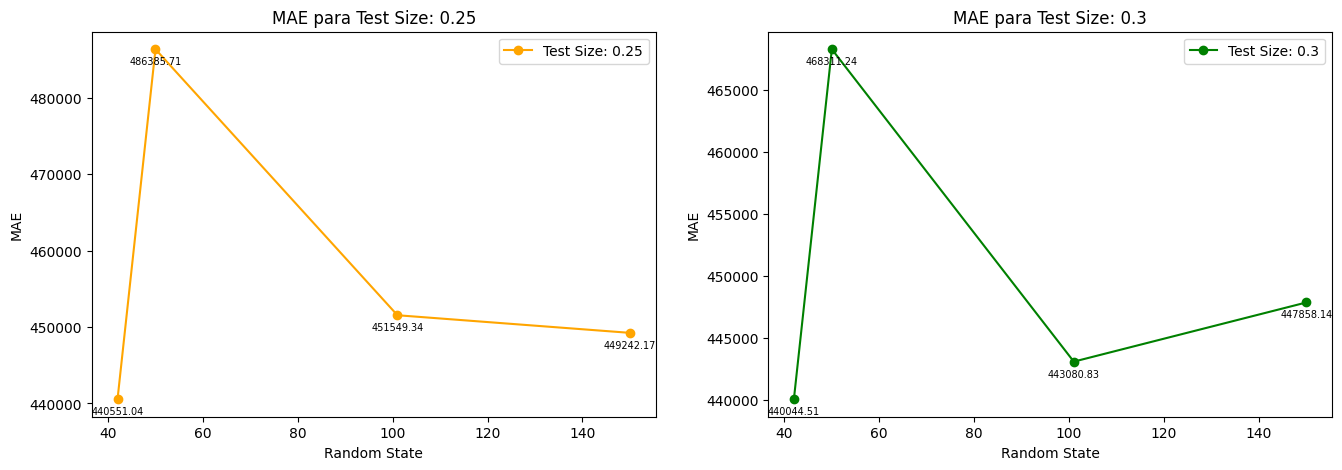

In [351]:
# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

model = LinearRegression()

resultados = get_mae_graficos(X,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 2 Imputacion de la moda en columnas Categóricas

In [352]:
data2 = df.copy()
# Cambiar los valores nulos con el valor de la moda en las columnas categóricas
columnasCategoricas = [col for col in data2.columns if data2[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data2[columna].mode()[0]
    data2[columna].fillna(moda, inplace=True)


El valor mínimo de MAE es: 472348.71 cuando test_size: 0.25 y random_state es: 101



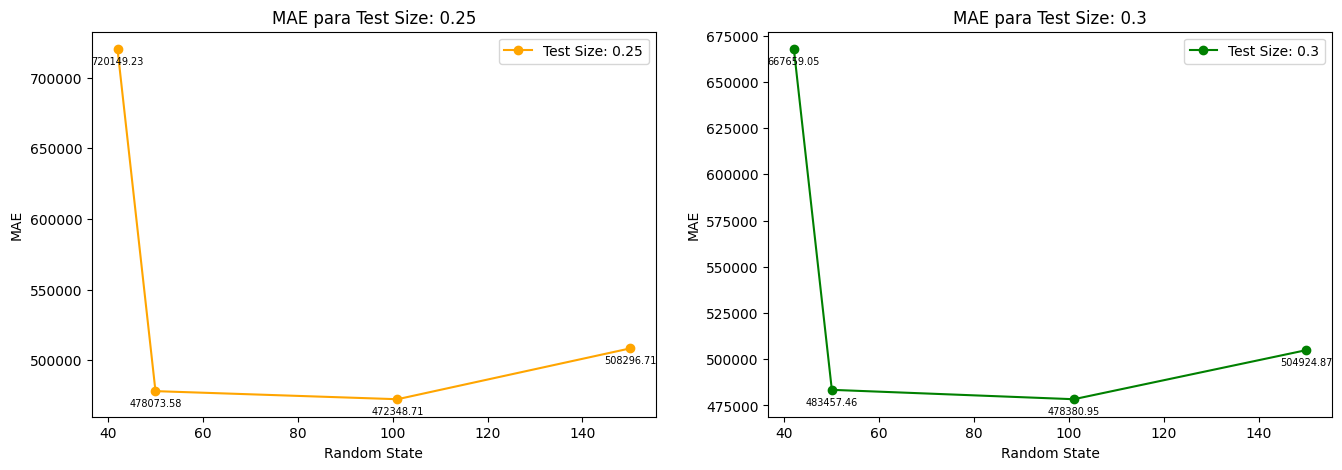

In [353]:
# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X2 = data2.drop(['precio'], axis=1).values
y2 = data2['precio'].values.reshape(-1, 1)

resultados = get_mae_graficos(X2,y2,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 3 Imputación mediante modelo de machine learning

El valor mínimo de MAE es: 455922.06 cuando test_size: 0.25 y random_state es: 101



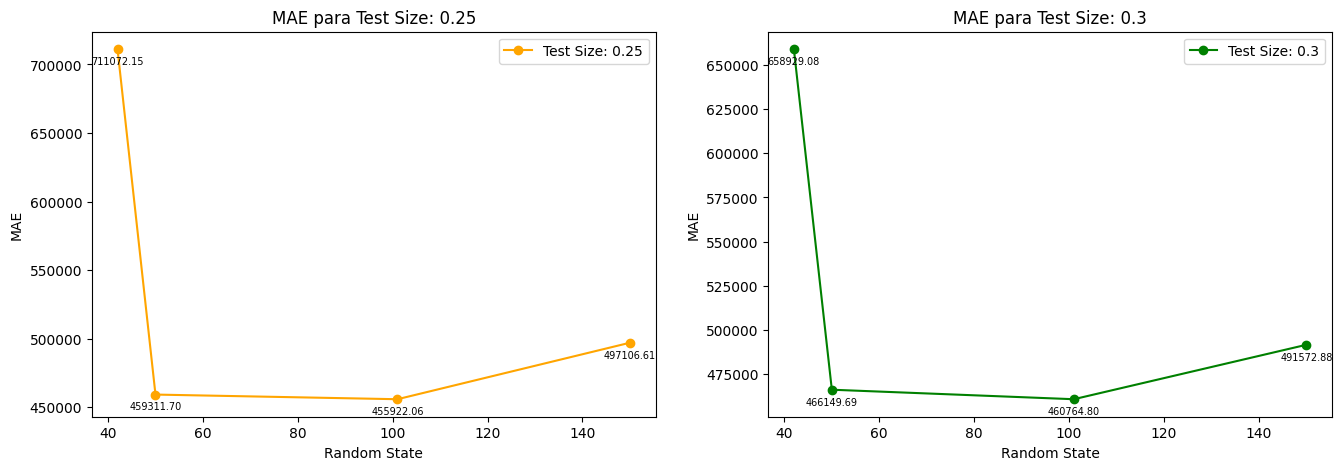

In [354]:
data = df.copy()

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

imputer = IterativeImputer(random_state=0)
X_imputed = imputer.fit_transform(X)

resultados = get_mae_graficos(X_imputed,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)


#### Modelo Final de Regresión

In [355]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)


# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)


## División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

#Escalamiento de las variables
scaler = StandardScaler()

scaler.fit(X_train)

#Aplicacion de la transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

modelo = LinearRegression()

# Entrenamiento del modelo utilizando el conjunto de entrenamiento
modelo.fit(X_train, y_train)

# Realizar predicciones utilizando el conjunto de prueba
y_pred = modelo.predict(X_test)


#### Métricas de evaluación de la regresión

In [356]:
# [MAE]  Error Absoluto Medio, es la media del valor absoluto de los errores
mae=round(mean_absolute_error(y_test, y_pred),4)

# [MSE]  Error Cuadrático Medio, es la media de los errores al cuadrado
mse=round(mean_squared_error(y_test, y_pred),4)

# [RMSE] - Error Cuadrático Medio Raíz, es la raíz cuadrada de la media de los errores al cuadrado
rmse=round(np.sqrt(mean_squared_error(y_test, y_pred)),4)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

MAE: 440044.5117, MSE: 500336252044.8925, RMSE: 707344.5073


#### Cross Validation con cross_val_score

In [357]:
scores = cross_val_score(modelo,X_train,y_train,
                         scoring='neg_mean_absolute_error',cv=5)
# Average of the MAE scores
abs(scores.mean())

479562.4688198737

#### Cross Validation con cross_validate

In [358]:
scores2 = cross_validate(modelo,X_train,y_train,
                         scoring=['neg_mean_absolute_error','neg_mean_squared_error','max_error'],cv=5)
pd.DataFrame(scores2).mean()

fit_time                        2.595472e-03
score_time                      1.792908e-03
test_neg_mean_absolute_error   -4.795625e+05
test_neg_mean_squared_error    -1.414855e+12
test_max_error                 -1.344070e+07
dtype: float64

#### Porcentaje del Costo Medio  

In [359]:
costo_medio_vivienda = data.precio.mean()
porcentaje_costo_medio = (mae/costo_medio_vivienda)*100
print("Porcentaje del Costo Medio: ", round(porcentaje_costo_medio,2),"%")

Porcentaje del Costo Medio:  45.57 %


#### Gráficas de Predicciones

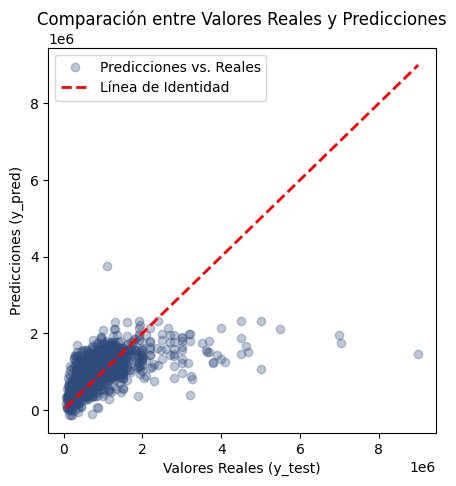

In [360]:
# Crear una figura
plt.figure(figsize=(5, 5),  dpi=100)

# Graficar los valores reales versus las predicciones
plt.scatter(y_test, y_pred, color='#2f4b7c', alpha=0.3, label='Predicciones vs. Reales')

# Etiquetas y título del gráfico
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred)')
plt.title('Comparación entre Valores Reales y Predicciones')

# Línea de identidad (y = x) donde los valores reales son iguales a las predicciones
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Línea de Identidad')

# Agregar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

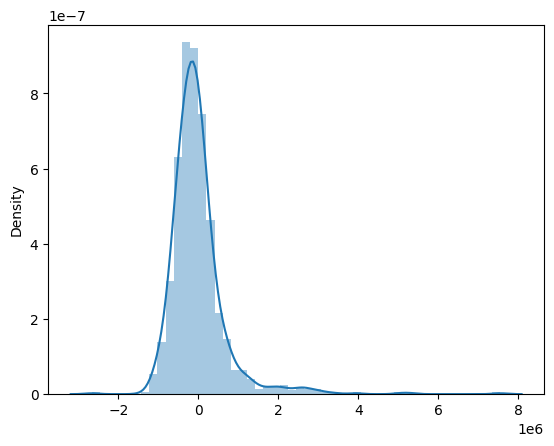

In [361]:
#Gráfica de residuales
sns.distplot((y_test-y_pred),bins=50);

Este tipo de gráfica evalua el rendimiento del modelo de regresión donde la distribución de los residuales debería tender a una distribución normal y deberían estar centrados alrededor de cero.

### GridSearchCV

#### Paso N° 1 Eliminando registros nulos de columnas Categóricas

El valor mínimo de MAE es: 441822.76 cuando test_size: 0.3 y random_state es: 42



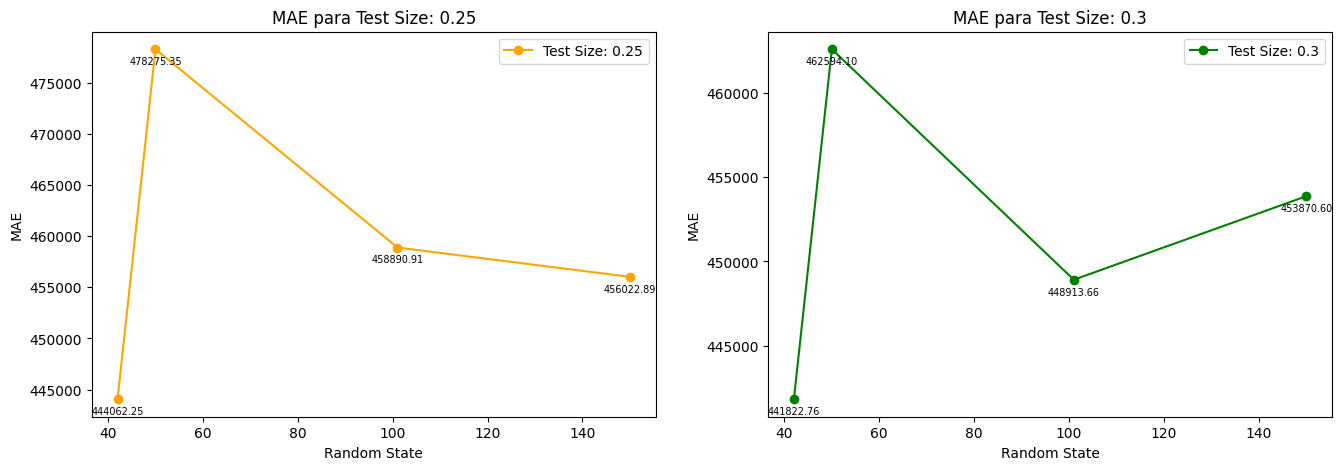

In [362]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

modelo = ElasticNet()

resultados = get_mae_graficos(X,y,modelo)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 2 Imputacion de la moda en columnas Categóricas

El valor mínimo de MAE es: 479620.71 cuando test_size: 0.25 y random_state es: 101



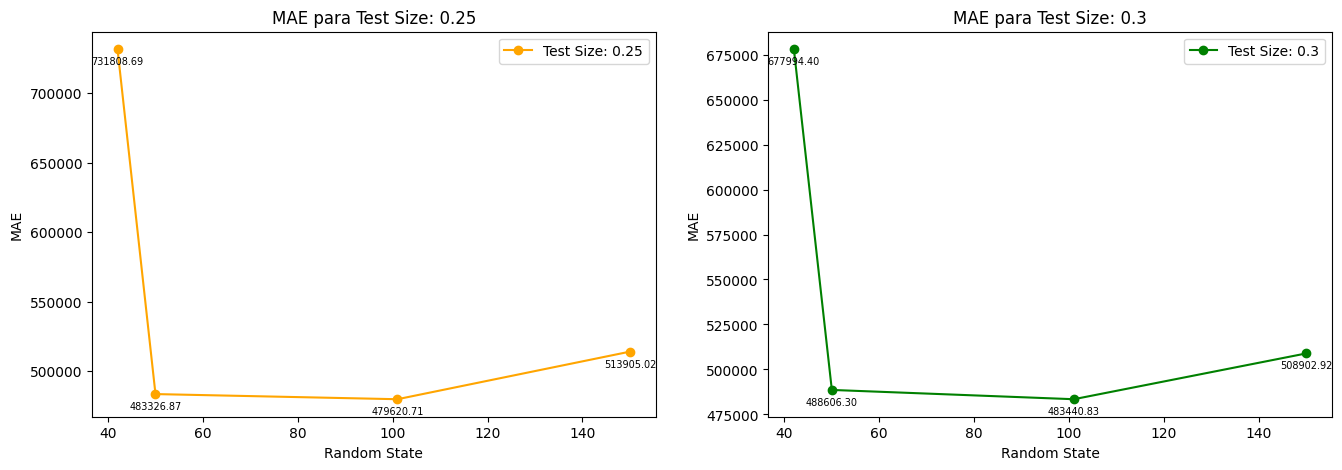

In [363]:
data = df.copy()
# Cambiar los valores nulos con el valor de la moda en las columnas categóricas
columnasCategoricas = [col for col in data.columns if data[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

modelo = ElasticNet()

resultados = get_mae_graficos(X,y,modelo)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)


#### Paso N° 3 Imputación mediante modelo de machine learning

El valor mínimo de MAE es: 462563.78 cuando test_size: 0.25 y random_state es: 101



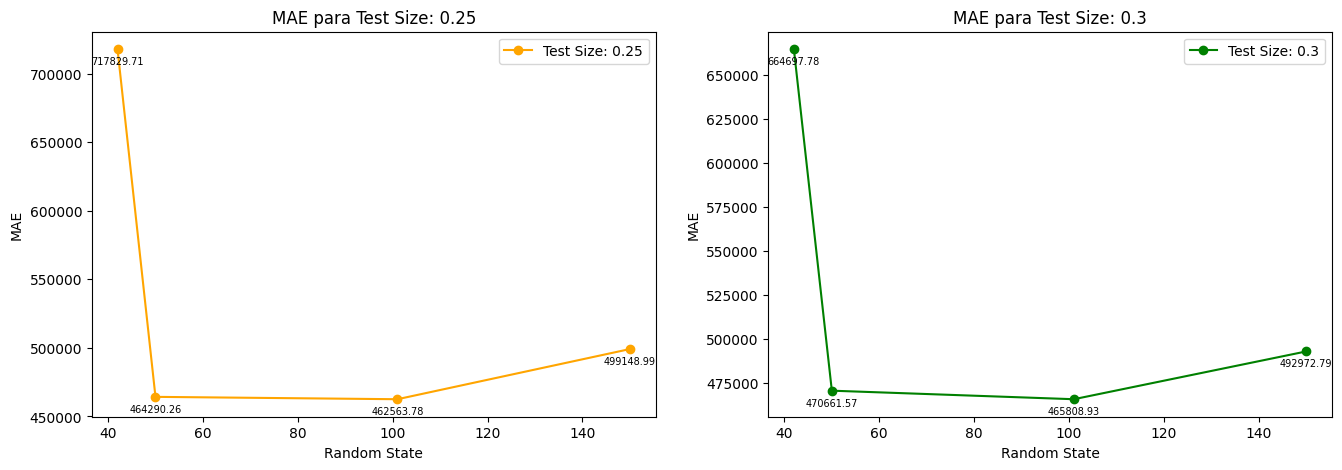

In [364]:
data = df.copy()

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

imputer = IterativeImputer(random_state=0)
X_imputed = imputer.fit_transform(X)

modelo = ElasticNet()
resultados = get_mae_graficos(X_imputed,y,modelo)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Modelo Final

In [365]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)


# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)


## División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

#Escalamiento de las variables predictoras y la variable objetivo
scaler = StandardScaler()

scaler.fit(X_train)

#Aplicacion de la transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

elastic_model = ElasticNet()

param_grid = {'alpha':[0.1,1,5,10,50,100],
              'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}

# verbose number a personal preference
grid_model = GridSearchCV(estimator=elastic_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1)

# Entrenamiento del modelo utilizando el conjunto de entrenamiento
grid_model.fit(X_train, y_train)



Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [366]:
grid_model.best_estimator_

ElasticNet(alpha=1, l1_ratio=0.1)

In [367]:
grid_model.best_params_

{'alpha': 1, 'l1_ratio': 0.1}

In [368]:

# Obtener los mejores hiperparámetros
best_hyperparameters = grid_model.best_params_

# Crear el modelo final con los mejores hiperparámetros
final_model = ElasticNet(alpha=best_hyperparameters['alpha'], l1_ratio=best_hyperparameters['l1_ratio'])

# Entrenar el modelo final en todo el conjunto de datos de entrenamiento
final_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de datos de prueba
predictions = final_model.predict(X_test)

# Evaluar el rendimiento del modelo final
final_mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {final_mae}')


MAE: 449532.89044424455


#### Cross Validation con cross_val_score

In [369]:
scores = cross_val_score(final_model,X_train,y_train,
                         scoring='neg_mean_absolute_error',cv=5)
# Average of the MAE scores
abs(scores.mean())

471424.3981217438

#### Porcentaje del Costo Medio

In [370]:
costo_medio_vivienda = data['precio'].mean()

# Imprimir el resultado
print("Costo Medio de una Vivienda:", round(costo_medio_vivienda,2))

Costo Medio de una Vivienda: 965669.36


In [371]:
porcentaje_costo_medio = (final_mae/costo_medio_vivienda)*100
print("Porcentaje del Costo Medio", round(porcentaje_costo_medio,2),"%")

Porcentaje del Costo Medio 46.55 %


### Decision Tree

#### Paso N° 1 Eliminando registros nulos de columnas Categóricas

El valor mínimo de MAE es: 422957.2 cuando test_size: 0.3 y random_state es: 42



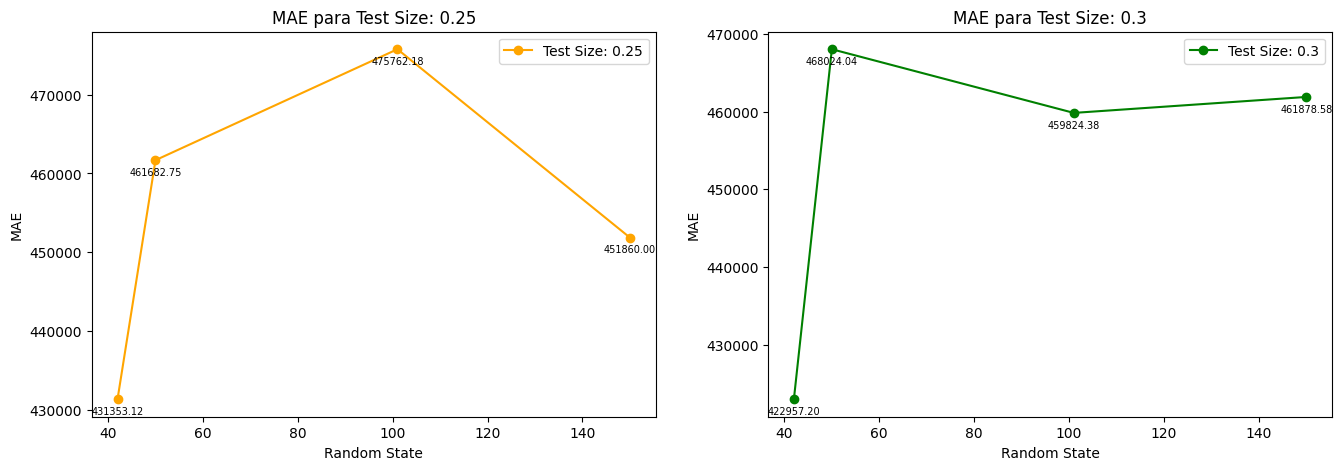

In [372]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

model = DecisionTreeRegressor(random_state=1)

resultados = get_mae_graficos(X,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)


#### Paso N° 2 Imputacion de la moda en columnas Categóricas

El valor mínimo de MAE es: 356403.44 cuando test_size: 0.25 y random_state es: 50



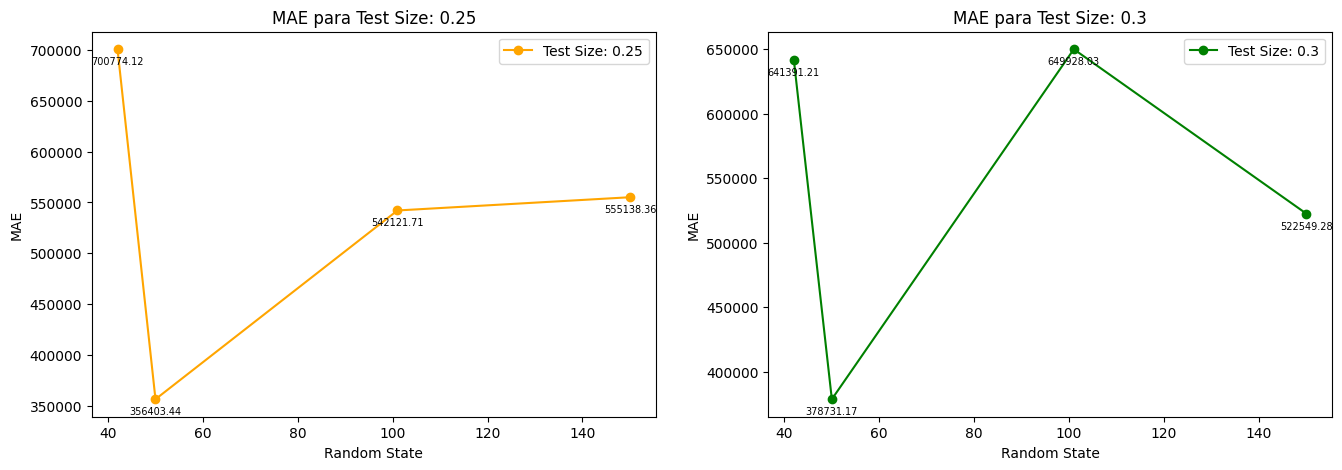

In [373]:
# Cambiar los valores nulos con el valor de la moda en las columnas categóricas
# Se optó por la opcion de Imputacion con el valor de la Moda ya que devolvio un MAE menor

data = df.copy()
columnasCategoricas = [col for col in data.columns if data[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

model = DecisionTreeRegressor(random_state=1)

resultados = get_mae_graficos(X,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 3 Imputación mediante modelo de machine learning

El valor mínimo de MAE es: 373870.32 cuando test_size: 0.25 y random_state es: 50



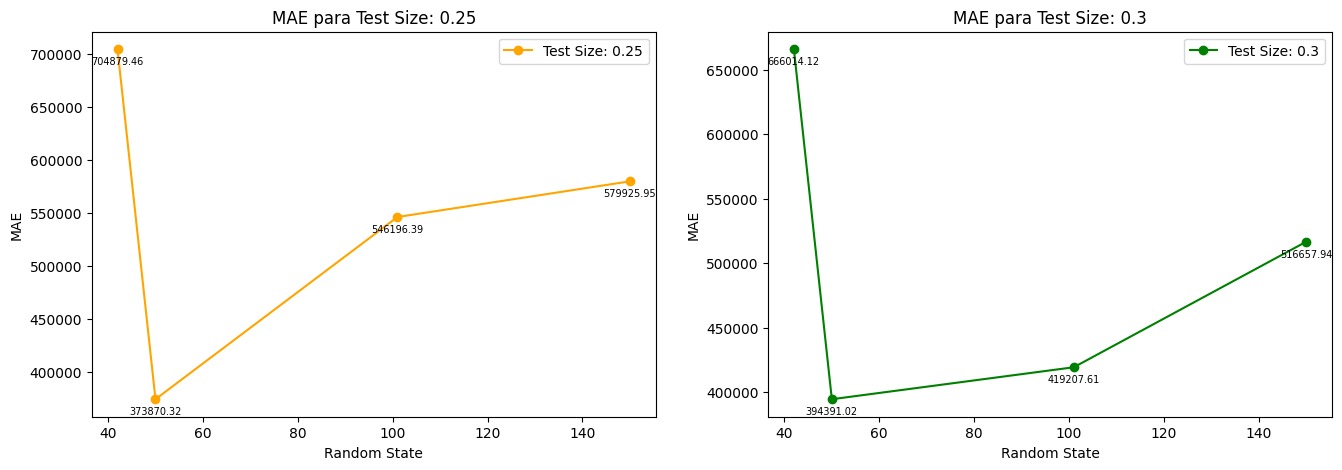

In [374]:
data = df.copy()

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

imputer = IterativeImputer(random_state=0)
X_imputed = imputer.fit_transform(X)

model = DecisionTreeRegressor(random_state=1)

resultados = get_mae_graficos(X_imputed,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

In [375]:
def get_mae(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return(mae)

#### Evaluacion del Tamaño Óptimo

In [376]:
data = df.copy()

columnasCategoricas = [col for col in data.columns if data[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

## División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(X, y,test_size=0.25, random_state=50)

#Escalamiento de las variables predictoras y la variable objetivo
scaler = StandardScaler()

scaler.fit(X_train)

#Aplicacion de la transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Specify Model
model = DecisionTreeRegressor(random_state=1)
# Fit Model
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [377]:
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
scores = {leaf_size: get_mae(leaf_size, X_train, X_test, y_train, y_test) for leaf_size in candidate_max_leaf_nodes}

# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = min(scores, key=scores.get)


In [378]:
best_tree_size

100

####  Modelo Final

In [379]:
data = df.copy()

columnasCategoricas = [col for col in data.columns if data[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

## División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=50)

#Escalamiento de las variables predictoras y la variable objetivo
scaler = StandardScaler()

scaler.fit(X_train)

#Aplicacion de la transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fill in argument to make optimal size and uncomment
final_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=1)

# fit the final model and uncomment the next two lines
final_model.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)

In [380]:
# Make validation predictions and calculate mean absolute error
final_predictions = final_model.predict(X_test)
mae = mean_absolute_error(y_test,final_predictions)
print("Validation MAE:",mae)

Validation MAE: 311200.5718867082


#### Cross Validation con cross_val_score

In [381]:
scores = cross_val_score(final_model,X_train,y_train,
                         scoring='neg_mean_absolute_error',cv=5)
# Average of the MAE scores
abs(scores.mean())

496686.0830251187

#### Porcentaje del Costo Medio

In [382]:
costo_medio_vivienda = data['precio'].mean()
print("Costo Medio de una Vivienda:", round(costo_medio_vivienda,2))

Costo Medio de una Vivienda: 911171.61


In [383]:
porcentaje_costo_medio = (mae/costo_medio_vivienda)*100
print("Porcentaje del Costo Medio: ", round(porcentaje_costo_medio,2),"%")

Porcentaje del Costo Medio:  34.15 %


###  Random Forest 

#### Paso N° 1 Eliminando registros nulos de columnas Categóricas

In [384]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)

El valor mínimo de MAE es: 347574.75 cuando test_size: 0.25 y random_state es: 150



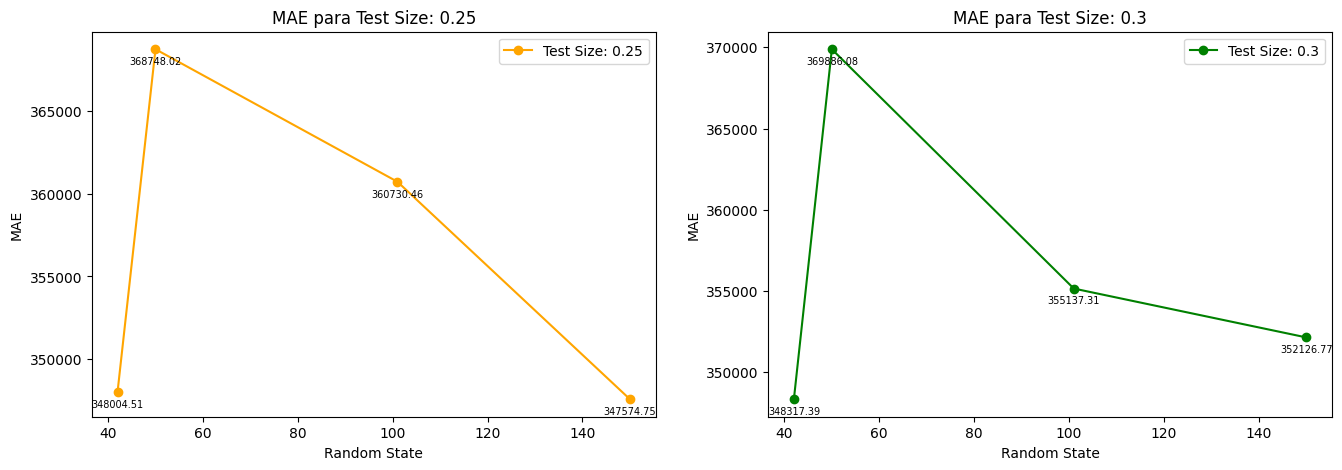

In [385]:
# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

modelo = RandomForestRegressor()

resultados = get_mae_graficos(X,y,modelo)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 2 Imputacion de la moda en columnas Categóricas

In [386]:
data = df.copy()
# Cambiar los valores nulos con el valor de la moda en las columnas categóricas
columnasCategoricas = [col for col in data.columns if data[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)

El valor mínimo de MAE es: 295090.79 cuando test_size: 0.25 y random_state es: 50



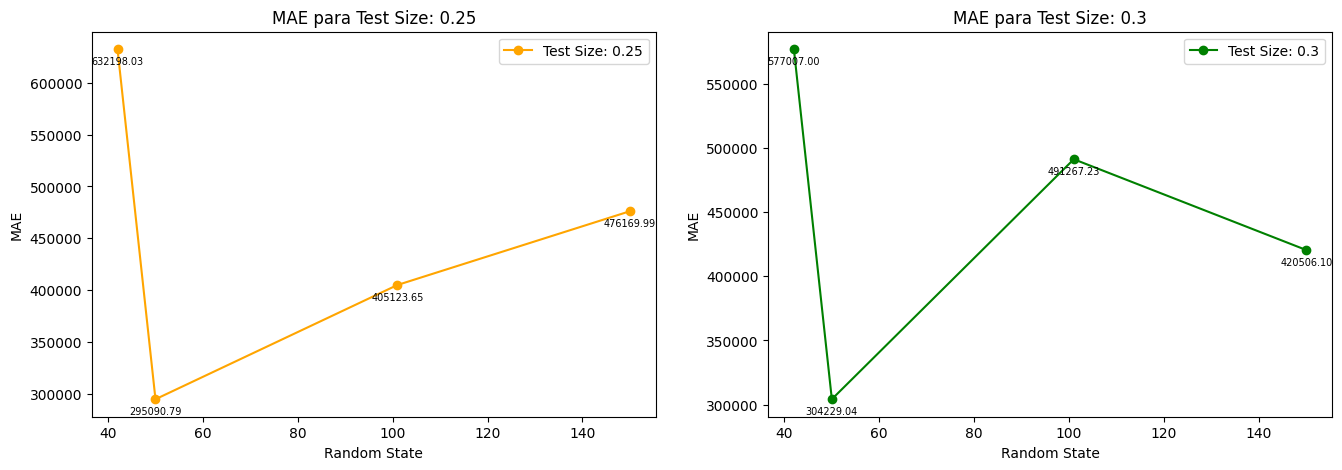

In [387]:
# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

modelo = RandomForestRegressor()

resultados = get_mae_graficos(X,y,modelo)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 3 Imputación mediante modelo de machine learning

El valor mínimo de MAE es: 351590.73 cuando test_size: 0.25 y random_state es: 50



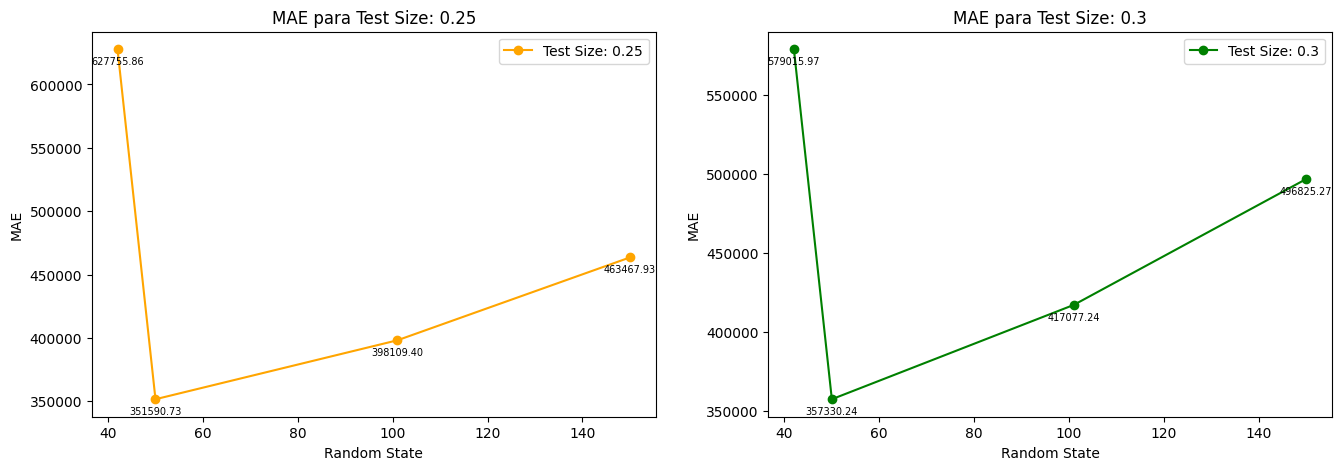

In [388]:
data = df.copy()

model = RandomForestRegressor()

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

imputer = IterativeImputer(random_state=0)
X_imputed = imputer.fit_transform(X)

resultados = get_mae_graficos(X_imputed,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Modelo Final

In [389]:
def run_model(model,X_train,y_train,X_test,y_test):

    # Fit Model
    model.fit(X_train,y_train)

    # Get Metrics
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test,preds)

    return mae

In [390]:
data = df.copy()

columnasCategoricas = [col for col in data.columns if data[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)


# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)


## División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=50)

#Escalamiento de las variables
scaler = StandardScaler()

scaler.fit(X_train)

#Aplicacion de la transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [391]:
results = []
trees = [10,50,100,150,200,250,300,350,400]
for n in trees:
    modelo = RandomForestRegressor(n_estimators=n)
    mae=run_model(modelo,X_train,y_train,X_test,y_test)
    results.append({'estimator': n, 'mae': mae})

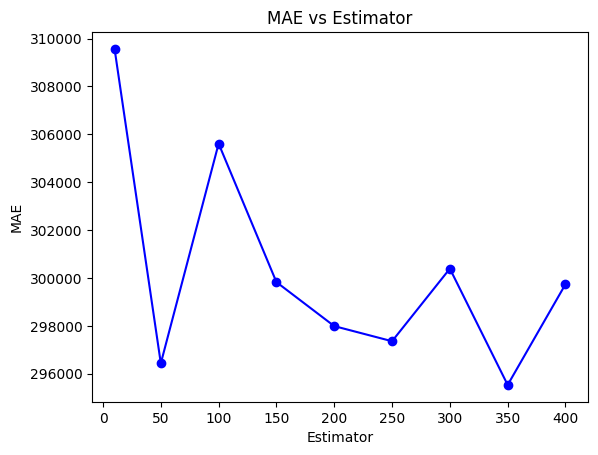

In [392]:
estimators = [result['estimator'] for result in results]
mae_values = [result['mae'] for result in results]

# Graficar
plt.plot(estimators, mae_values, marker='o', linestyle='-', color='b')
plt.title('MAE vs Estimator')
plt.xlabel('Estimator')
plt.ylabel('MAE')
plt.show()

In [393]:
min_mae_result = min(results, key=lambda x: x['mae'])
estimator_result_forest= min_mae_result['estimator']
print('mae',min_mae_result['mae'],'estimator', estimator_result_forest)

mae 295533.084016733 estimator 350


#### Porcentaje del Costo Medio

In [394]:
costo_medio_vivienda = data['precio'].mean()

# Imprimir el resultado
print("Costo Medio de una Vivienda:", round(costo_medio_vivienda,2))

porcentaje_costo_medio = (min_mae_result['mae']/costo_medio_vivienda)*100
print("Porcentaje del Costo Medio", round(porcentaje_costo_medio,2),"%")

Costo Medio de una Vivienda: 911171.61
Porcentaje del Costo Medio 32.43 %


### XGBoost

#### Paso N° 1 Eliminando registros nulos de columnas Categóricas

In [395]:
data = df.copy()
categoryColumns =  [col for col in data.columns if data[col].isnull().any()]
data = data.dropna(subset=categoryColumns)
data = data.reset_index(drop=True)

El valor mínimo de MAE es: 375552.73 cuando test_size: 0.25 y random_state es: 150



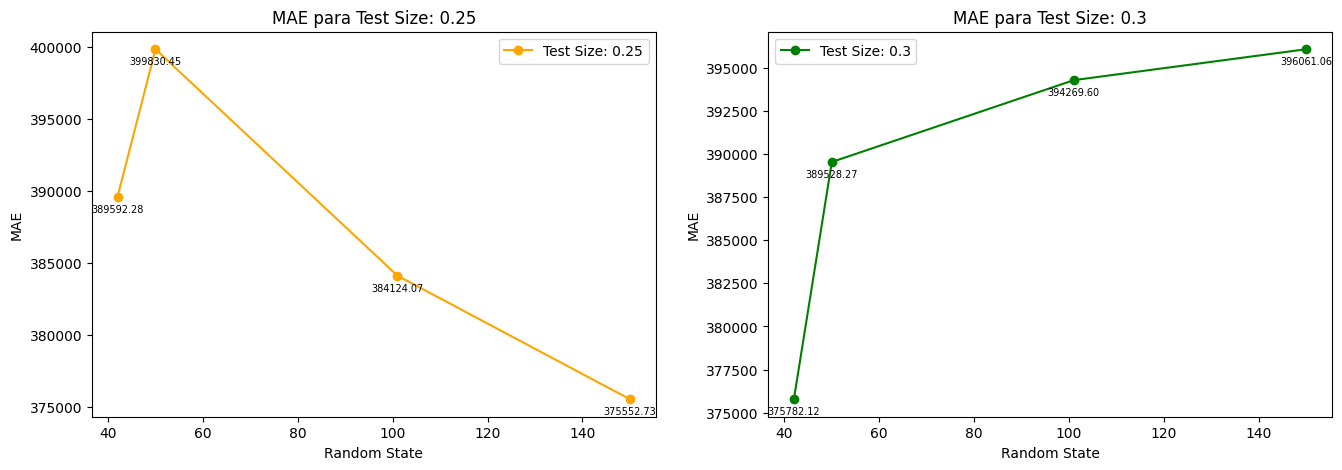

In [396]:
# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

model = XGBRegressor()

resultados = get_mae_graficos(X,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 2 Imputacion de la moda en columnas Categóricas

In [397]:
data = df.copy()
# Cambiar los valores nulos con el valor de la moda en las columnas categóricas
columnasCategoricas = [col for col in data.columns if data[col].isnull().any()]

for columna in columnasCategoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)


El valor mínimo de MAE es: 335198.39 cuando test_size: 0.3 y random_state es: 50



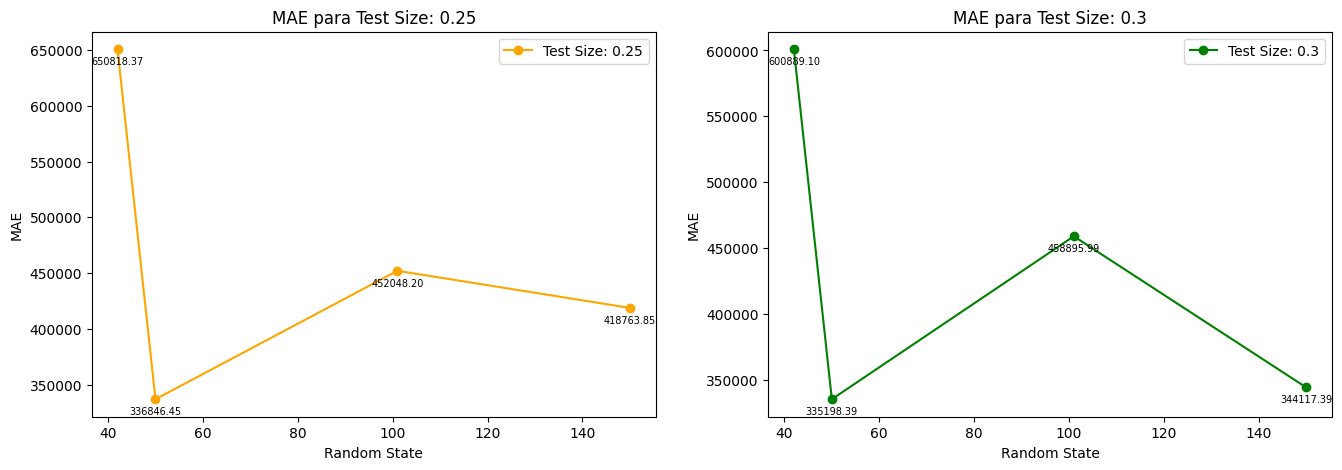

In [398]:
# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

model = XGBRegressor()

resultados = get_mae_graficos(X,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)

#### Paso N° 3 Imputación mediante modelo de machine learning

El valor mínimo de MAE es: 343746.73 cuando test_size: 0.25 y random_state es: 101



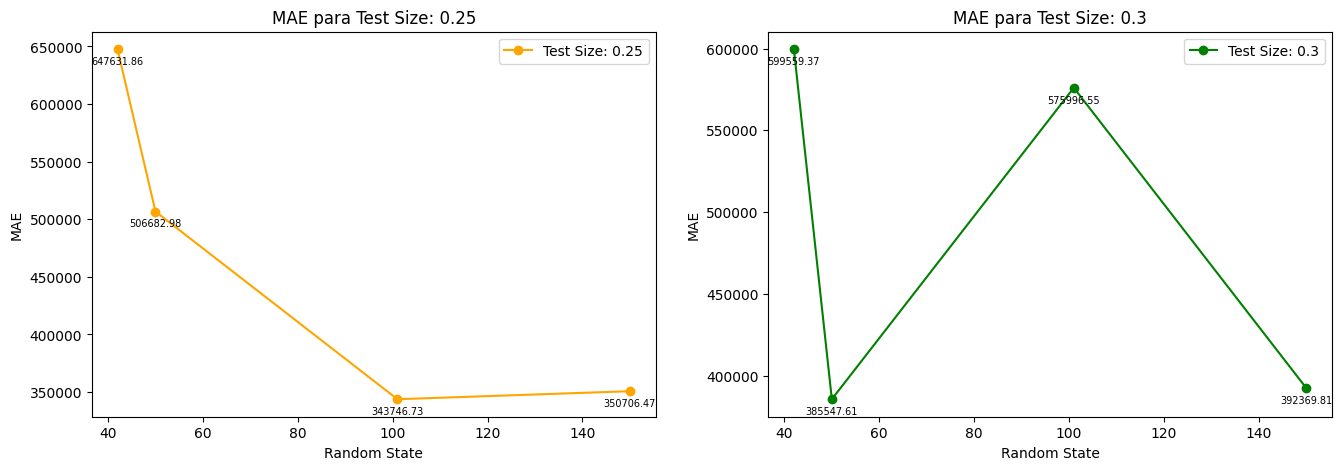

In [399]:
data = df.copy()

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)

model = XGBRegressor()

imputer = IterativeImputer(random_state=0)
X_imputed = imputer.fit_transform(X)

resultados = get_mae_graficos(X_imputed,y,model)
mensaje = f"El valor mínimo de MAE es: {round(resultados['mae'],2)} cuando test_size: {resultados['test_size']} y random_state es: {resultados['random_state']}\n"
print(mensaje)


##### Modelo Final

In [400]:
data = df.copy()

# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = data.drop(['precio'], axis=1).values
y = data['precio'].values.reshape(-1, 1)



imputer = IterativeImputer(random_state=0)
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=50)

# Escalamiento de las variables
scaler = StandardScaler()

scaler.fit(X_train)

#Aplicacion de la transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [401]:
results = []
nestimators = [0,1,100,500,1000,1500]
for n in nestimators:
    modelo = XGBRegressor(n_estimators=n, learning_rate=0.05)
    mae=run_model(modelo,X_train,y_train,X_test,y_test)
    results.append({'estimator': n, 'mae': mae})

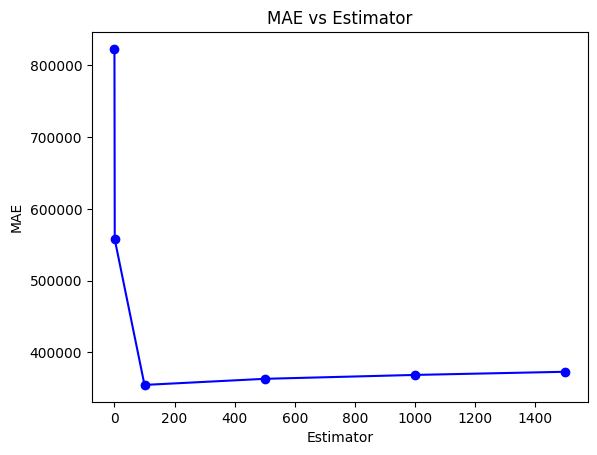

In [402]:
estimators = [result['estimator'] for result in results]
mae_values = [result['mae'] for result in results]

# Graficar
plt.plot(estimators, mae_values, marker='o', linestyle='-', color='b')
plt.title('MAE vs Estimator')
plt.xlabel('Estimator')
plt.ylabel('MAE')
plt.show()

In [403]:
mae_result = min(results, key=lambda x: x['mae'])
print('mae',min_mae_result['mae'],'estimator', min_mae_result['estimator'])

mae 295533.084016733 estimator 350


#### Porcentaje del Costo Medio

In [404]:
costo_medio_vivienda = data['precio'].mean()

# Imprimir el resultado
print("Costo Medio de una Vivienda:", round(costo_medio_vivienda,2))

porcentaje_costo_medio = (mae_result['mae']/costo_medio_vivienda)*100
print("Porcentaje del Costo Medio", round(porcentaje_costo_medio,2),"%")

Costo Medio de una Vivienda: 911171.61
Porcentaje del Costo Medio 38.93 %


### Modelo Final

In [405]:
categoryColumns =  [col for col in df.columns if df[col].isnull().any()]
df = df.dropna(subset=categoryColumns)
df = df.reset_index(drop=True)


# Extraccion los valores de las variables predictoras (X) y la variable objetivo (y)
X = df.drop(['precio'], axis=1).values
y = df['precio'].values.reshape(-1, 1)


## División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=50)

#Escalamiento de las variables
scaler = StandardScaler()

scaler.fit(X_train)

#Aplicacion de la transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

modelo = RandomForestRegressor(n_estimators=estimator_result_forest)

# Entrenamiento del modelo utilizando el conjunto de entrenamiento
modelo.fit(X_train,y_train)

y_pred = modelo.predict(X_test)


In [406]:
#Utilizando la biblioteca pickle de Python para generar un archivo que guardará el modelo
pickle_out = open("modelo/modelo.pkl","wb")
pickle.dump(modelo, pickle_out)
pickle_out.close()